# Example: Using Loman to price Interest Rate Swaps

In this example, we'll look at calibrating interest rate curves to market prices, and then using them to price portfolios of swaps.

## Curve Classes

Because the focus will be on using Loman, we'll adopt deliberately simplifying assumptions; time is a float, day count and business day conventions are ignored, quarters are exactly 0.25 years long and so on.

Our interest rate curves can be used for two things: discounting and projecting rates. To do this, we define a continuously-compounded forward rate $r(t)$, so that the discount rate from a payment at time $t$ to a time $s$ is 
\begin{equation} df(s,t) = \exp\left[-\int_s^t r(\tau) d\tau\right] \end{equation}
and zero/FRA rates are defined by
\begin{equation} df(s,t) = \frac{1}{1+\text{FRA}(s,t)(t-s)}. \end{equation}

Our BaseIRCurve class leaves the definition of $r$ blank, but otherwise fleshes out the methods we'll need, including methods to PV a set of cashflows, and also to plot the continuously-compounded forward rate, 3M FRA rates, and spot swap rates (once we define swap_rate, further below).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad


class BaseIRCurve:
    def r_quad(self, s, t):
        b = np.broadcast(s, t)
        out = np.empty(b.shape)
        out.flat = [quad(self.r, s0, t0)[0] for s0, t0 in b]
        return out

    def r(self, t):
        pass

    def df(self, s, t):
        return np.exp(-self.r_quad(s, t))

    def fra(self, s, t):
        return (1 / self.df(s, t) - 1.0) / (t - s)

    def pv(self, amts, ts, s=0):
        dfs = self.df(s, ts)
        return np.sum(amts * dfs)

    def plot(self):
        ts = np.linspace(0.0, 29.75, 360)
        plt.plot(ts, self.r(ts), label="r")
        ts = np.linspace(0.0, 29.75, 120)
        plt.plot(ts, self.fra(ts, ts + 0.25), label="3M fwd")
        plt.plot(ts, np.vectorize(swap_rate)(0, ts, 0.25, self, self), label="Swap Rate")
        plt.legend()

The FlatIRCurve class fills out the definitions of r and r_quad. $r(t)$ is piece-wise flat, and hence its integral is piecewise linear. Together with the methods defined by BaseIRCurve we will now have a basic but functional interest rate curve.

In [2]:
class FlatIRCurve(BaseIRCurve):
    def __init__(self, ts, rates):
        self.ts = ts
        self.rates = rates
        self.ts0 = np.zeros(len(self.ts) + 1)
        self.ts0[1:] = self.ts
        self.rquads = np.zeros_like(self.ts0)
        self.rquads[1:] = np.cumsum(np.diff(self.ts0) * self.rates)

    def r(self, t):
        idx = np.minimum(np.searchsorted(self.ts, t, "right"), len(self.ts) - 1)
        return self.rates[idx]

    def r_quad(self, s, t):
        return np.interp(t, self.ts0, self.rquads) - np.interp(s, self.ts0, self.rquads)

Finally, we'll need to set up some functions to calculate quarterly FRAs and discount them to calculate PVs of the fixed and floating legs of swaps, as well as the swap rate.

In [3]:
def sched(a, b, p):
    n = int((b - a) / p)
    if b - n * p > a + p / 2.0:
        n = n + 1
    ts = np.linspace(b - n * p, b, n + 1)
    ts[0] = a
    return ts


def swap_leg_pvs(a, b, p, projection_curve, discount_curve):
    ts = sched(a, b, p)
    pers = np.diff(ts)
    fixed_pv = discount_curve.pv(pers, ts[1:])
    fras = projection_curve.fra(ts[:-1], ts[1:])
    float_pv = discount_curve.pv(pers * fras, ts[1:])
    return fixed_pv, float_pv


def swap_rate(a, b, p, projection_curve, discount_curve):
    fixed_pv, float_pv = swap_leg_pvs(a, b, p, projection_curve, discount_curve)
    return float_pv / fixed_pv

## Calibrating a LIBOR curve

Up until 2008, it was standard to use the LIBOR curve for both projection of LIBOR swap cashflows *and* for discounting those cashflows. We set up a Loman computation with inputs **usd_libor_ts**, a set of swap maturities, and **usd_libor_c_rate** a set of continuous compounding rates for each period. From those, we create a curve object **usd_libor_curve**, and then calculate swap rates using that curve for both projection and discounting, in **usd_libor_swap_rates**.

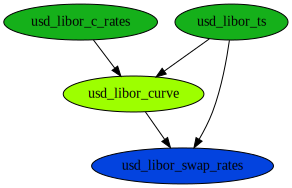

In [4]:
import loman

comp = loman.Computation()
comp.add_node("usd_libor_ts", value=np.array([1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0]))
comp.add_node("usd_libor_c_rates", value=0.03 * np.ones(9))
comp.add_node("usd_libor_curve", lambda usd_libor_ts, usd_libor_c_rates: FlatIRCurve(usd_libor_ts, usd_libor_c_rates))
comp.add_node(
    "usd_libor_swap_rates",
    lambda usd_libor_curve, usd_libor_ts: np.vectorize(swap_rate)(
        0, usd_libor_ts, 0.25, usd_libor_curve, usd_libor_curve
    ),
)
comp.draw()

If we calculate all the nodes in Loman, we can plot the curve. Because we set all the continuously compounding rates to 3%, it's not a very interesting curve yet.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


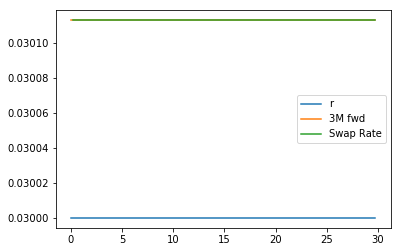

In [5]:
comp.compute_all()
comp.value("usd_libor_curve").plot()

Now, to help calibrate our curve, we add a node that is market swap rates (**usd_libor_mkt_swap_rates**), and calculate the difference between the rates our curve is producing, and the market rates we are trying to fit to, in **usd_libor_fitting_error**.

In [6]:
comp.add_node(
    "usd_libor_mkt_swap_rates",
    value=np.array([0.01364, 0.01593, 0.01776, 0.02023, 0.02181, 0.02343, 0.02499, 0.02566, 0.02593]),
)
comp.add_node(
    "usd_libor_fitting_error",
    lambda usd_libor_swap_rates, usd_libor_mkt_swap_rates: usd_libor_swap_rates - usd_libor_mkt_swap_rates,
)

To calibrate our curve, we use a minimizer from scipy. Our objective function is to insert a trial set of continuously-compounded rates into the input **usd_libor_c_rates**, calculate the error vector **usd_libor_fitting_error** using Loman, and then return the sum of the squares (scaled appropriately for the solver). Our initial guess is taken from the current set of rates in **usd_libor_c_rates**.

In [7]:
from scipy.optimize import minimize


def error(xs):
    comp.insert("usd_libor_c_rates", xs)
    comp.compute("usd_libor_fitting_error")
    return 10000.0 * np.sum(comp.value("usd_libor_fitting_error") ** 2)


res = minimize(error, comp.value("usd_libor_c_rates"))
res.success, res.nfev

(True, 275)

The solver indicates that it rans successfully with 275 evaluations, so we insert its solution set of input rates into the computation (solvers aren't required that their last evaluation be the solution value), re-compute everything, and plot the resulting curve. We also show the market swap rates so we can see our calibration was successful.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


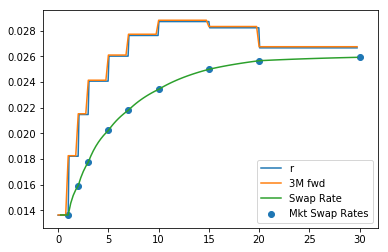

In [8]:
comp.insert("usd_libor_c_rates", res.x)
comp.compute_all()
comp.value("usd_libor_curve").plot()
plt.scatter(comp.value("usd_libor_ts"), comp.value("usd_libor_mkt_swap_rates"), label="Mkt Swap Rates")
plt.legend()

## Valuing a Portfolio of Interest Rate Swaps

Now that we have a valid interest rate curve, we can use it to value interest rate swaps. For now, our swaps will all be valued with using the same USD LIBOR curve.

We define a swap as a collection of named parameters, create a function to value them, and add a node **portfolio** to our computation, which is a set of swaps

In [9]:
from collections import namedtuple

Swap = namedtuple("Swap", ["notional", "start", "end", "rate", "freq"])


def swap_pv(swap, projection_curve, discount_curve):
    fixed_pv, float_pv = swap_leg_pvs(swap.start, swap.end, swap.freq, projection_curve, discount_curve)
    return swap.notional * (float_pv - swap.rate * fixed_pv)


comp.add_node("portfolio", value=[Swap(10000000, 5, 10, 0.025, 0.25), Swap(-5000000, 2.5, 12.5, 0.02, 0.25)])

To value our portfolio, we simply apply our valuation function to each position in our portfolio, and Loman gives us an array back, with the value of each position

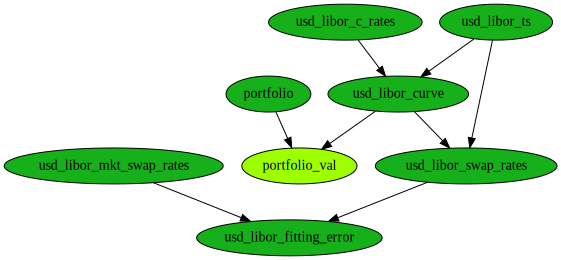

In [10]:
comp.add_node(
    "portfolio_val",
    lambda portfolio, usd_libor_curve: [swap_pv(swap, usd_libor_curve, usd_libor_curve) for swap in portfolio],
)
comp.draw()

In [11]:
comp.compute_all()
comp.value("portfolio_val")

[86395.045323357786, -274086.54029392399]

## Dual Bootstrap Curves

Since 2008, the spread between LIBOR and OIS has been material, and it is standard practice to calibrate curves to LIBOR swaps and LIBOR-OIS basis swaps, say. To start, we'll need some inputs, a curve, and the market rates.

In [12]:
comp.add_node("usd_ois_ts", value=np.array([1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0]))
comp.add_node("usd_ois_c_rates", value=0.03 * np.ones(9))
comp.add_node("usd_ois_curve", lambda usd_ois_ts, usd_ois_c_rates: FlatIRCurve(usd_ois_ts, usd_ois_c_rates))
comp.add_node("usd_libor_ois_mkt_spreads", value=np.array([24.2, 26, 27.2, 29, 30.9, 33.4, 36.4, 38, 39.8]) / 10000.0)

Now we need a function to calculate LIBOR-OIS spreads from our two curves using
\begin{equation} PV_\text{LIBOR float leg} = PV_\text{OIS float leg} + s \times PV_\text{OIS 1bp fixed leg} \end{equation}

In [13]:
def swap_spread(a, b, p, projection_curve1, projection_curve2, discount_curve):
    fixed_pv1, float_pv1 = swap_leg_pvs(a, b, p, projection_curve1, discount_curve)
    fixed_pv2, float_pv2 = swap_leg_pvs(a, b, p, projection_curve2, discount_curve)
    return (float_pv1 - float_pv2) / fixed_pv2

We use that function to calculate LIBOR-OIS spreads using our two curves, as well as another fitting error vector that we will use in calibration.

In [14]:
comp.add_node(
    "usd_libor_ois_spreads",
    lambda usd_libor_curve, usd_ois_curve, usd_ois_ts: np.vectorize(swap_spread)(
        0, usd_ois_ts, 0.25, usd_libor_curve, usd_ois_curve, usd_ois_curve
    ),
)

comp.add_node(
    "usd_libor_ois_fitting_error",
    lambda usd_libor_ois_spreads, usd_libor_ois_mkt_spreads: usd_libor_ois_spreads - usd_libor_ois_mkt_spreads,
)

We should also update our LIBOR swap rate calculation to use our OIS curve for discounting:

In [15]:
comp.add_node(
    "usd_libor_swap_rates",
    lambda usd_libor_curve, usd_ois_curve, usd_libor_ts: np.vectorize(swap_rate)(
        0, usd_libor_ts, 0.25, usd_libor_curve, usd_ois_curve
    ),
)

Finally, for our calibration, it would be more convenient if we could just insert one vector, containing both LIBOR and OIS inputs, and have those feed through into **usd_libor_c_rates** and **usd_ois_c_rates**. Thanks to Loman, we can do this by giving them a common parent node. If we later want to insert values directly into **usd_libor_c_rates** and **usd_ois_c_rates**, then we can do that too, even though they are calculation nodes. We also define a node  **usd_fitting_error** to collect the fitting error vectors.

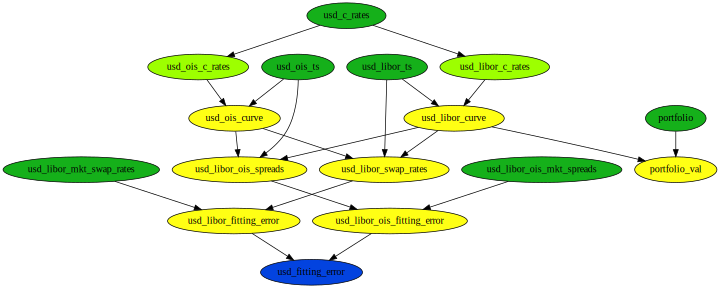

In [16]:
comp.add_node("usd_c_rates", value=0.03 * np.ones(18))
comp.add_node("usd_libor_c_rates", lambda usd_c_rates: usd_c_rates[0:9])
comp.add_node("usd_ois_c_rates", lambda usd_c_rates: usd_c_rates[9:18])
comp.add_node(
    "usd_fitting_error",
    lambda usd_libor_fitting_error, usd_libor_ois_fitting_error: np.concatenate(
        [usd_libor_fitting_error, usd_libor_ois_fitting_error]
    ),
)
comp.draw(graph_attr={"size": "10,8"})

Complicated.

But it's ok. Loman can take care of this.

We can just apply the same method as before. Having the solver insert sets of inputs, and iterate until it has minimized the error. This time, the set of inputs that it is adjusting flow into the construction of two separate curves, **usd_ois_curve**, and **usd_libor_curve**.

In [17]:
def error(xs):
    comp.insert("usd_c_rates", xs)
    comp.compute("usd_fitting_error")
    return 10000.0 * np.sum(comp.value("usd_fitting_error") ** 2)


res = minimize(error, comp.value("usd_c_rates"))
res.success, res.nfev

(True, 780)

In [18]:
comp.insert("usd_c_rates", res.x)
comp.compute_all()

Finally, we can plot LIBOR-OIS spreads from our dual boot-strapped curve, as well as LIBOR and OIS swap rates, to check the calibration.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


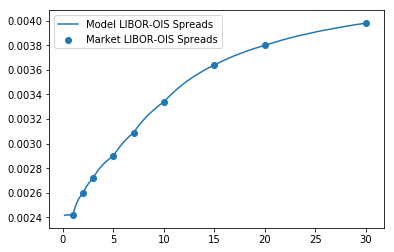

In [19]:
ts = np.linspace(0.0, 29.75, 360)
spreads = np.vectorize(swap_spread)(
    0.0, ts, 0.25, comp.value("usd_libor_curve"), comp.value("usd_ois_curve"), comp.value("usd_ois_curve")
)
plt.plot(ts, spreads, label="Model LIBOR-OIS Spreads")
plt.scatter(comp.value("usd_ois_ts"), comp.value("usd_libor_ois_mkt_spreads"), label="Market LIBOR-OIS Spreads")
plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


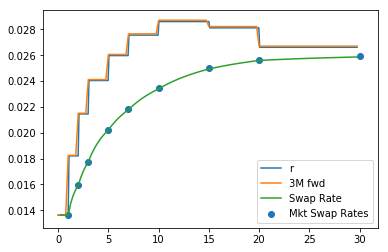

In [20]:
comp.value("usd_libor_curve").plot()
plt.scatter(comp.value("usd_libor_ts"), comp.value("usd_libor_mkt_swap_rates"), label="Mkt Swap Rates")
plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


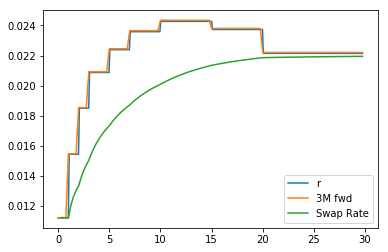

In [21]:
comp.value("usd_ois_curve").plot()

## Revisiting Portfolio Valuation

Now that we have two curves, and our swaps could potentially be projected and discounted with different curves, it's appropriate to introduce a new node, **curveset** and have the valuation of our portfolio depend on that curveset, rather than pointing directly at specific curves. When we create **curveset**, we can also put in a check that our fit was good.

We update the design of our Swap instrument, and recreate the portfolio with the additional information.

By design, Loman lets us redefine the function that calculates portfolio_val and have it depend on **curveset** rather than **usd_libor_curve**, and the Swap instruments themselves direct curves to take from **curveset** to perform valuation.

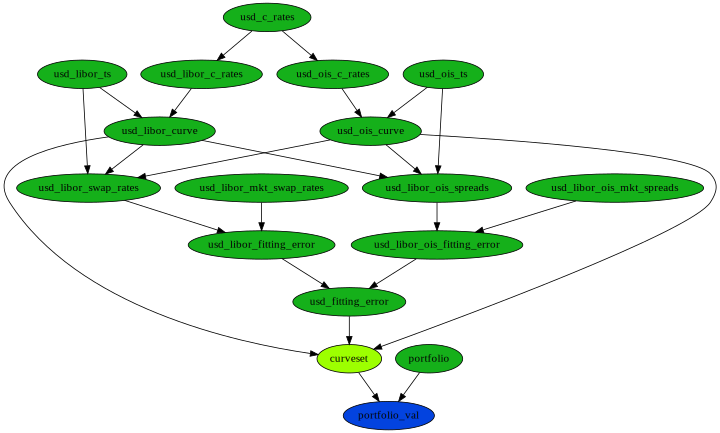

In [22]:
Swap = namedtuple("Swap", ["notional", "start", "end", "rate", "freq", "projection_curve", "discount_curve"])


def create_curveset(usd_libor_curve, usd_ois_curve, usd_fitting_error):
    if np.max(np.abs(usd_fitting_error) > 0.00001):
        raise Exception("Fitting error > 0.1bps")
    return {"USD-LIBOR-3M": usd_libor_curve, "USD-OIS": usd_ois_curve}


comp.add_node("curveset", create_curveset)

comp.insert(
    "portfolio",
    [
        Swap(10000000, 5, 10, 0.025, 0.25, "USD-LIBOR-3M", "USD-OIS"),
        Swap(-5000000, 2.5, 12.5, 0.02, 0.25, "USD-LIBOR-3M", "USD-OIS"),
    ],
)

comp.add_node(
    "portfolio_val",
    lambda portfolio, curveset: [
        swap_pv(swap, curveset[swap.projection_curve], curveset[swap.discount_curve]) for swap in portfolio
    ],
)
comp.draw(graph_attr={"size": "10,8"})

Finally, we can see that our valuation is close but materially different to the previous LIBOR-only curve's result (86,395 and -274,086), exactly as we expect.

In [23]:
comp.compute("portfolio_val")
comp.value("portfolio_val")

[85859.407115714959, -278864.22970371263]

# Risks

There are a few ways to calculate risk for a book of interest rate derivatives:
  
  * Spot risks directly. We can directly perturb the inputs **usd_libor_mkt_swap_rates** or **usd_libor_ois_mkt_spreads** one element at a time, recalibrating, and repricing the portfolio each time.
  * Spot risks, using Jacobians. We can perturb the inputs **usd_libor_c_rates** and **usd_ois_c_rates**, using the changes in **usd_libor_swap_rates** and **usd_libor_ois_spreads** to calculate a Jacobian. Applying the inverse of this Jacobian matrix on the matrix of portfolio valuation changes gives us the sensitivities to market instruments as above, without the need to recalibrate.
  * Forward risk. We can directly perturb the curve using $r'(t; a,b) = r(t) + \delta I_{a \le t < b}$ to create a new curve where the continuously-compounded rate is elevated in the region $[a,b)$. This will cause the forward swap rate to change by some amount, and by scaling $\delta$, we can make that amount 1bp (or we can scale the PV changes to the same effect), so we can get the risk for our portfolio to a set of forwards, potentially with much higher granularity than our initial set of calibration instruments. Additionally this method is more numerically stable when using non-local interpolations for curve construction.
  
For this exposition, we will go with the latter method, and to keep things moving along, we will only produce risks to the LIBOR curve.

To accommodate this change, we'll create a new node called **usd_libor_curve_perturbed** which will be fed into **curveset** for valuation, and will itself be created from **usd_libor_curve** and a control input called **usd_libor_curve_perturbation**.

First things first, we need to define how to create a perturbed curve, using the recipe above. Note that once we've defined r and r_quad, everything else will flow through

In [24]:
class SumCurve(BaseIRCurve):
    def __init__(self, *curves):
        self.curves = curves

    def r_quad(self, s, t):
        return sum(curve.r_quad(s, t) for curve in self.curves)

    def r(self, t):
        return sum(curve.r(t) for curve in self.curves)


def create_perturbed_curve(curve, start, end, amount):
    pert_curv = FlatIRCurve(np.array([start, end, np.max(curve.ts)]), np.array([0.0, amount, 0.0]))
    return SumCurve(curve, pert_curv)

To test this is working, we can see what happens when we bump the continuously-compounded rate by 5% between years 5 and 10 for example.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


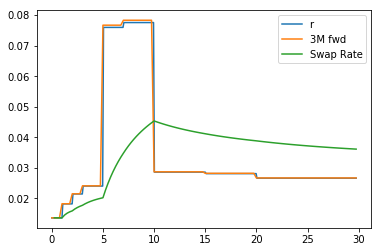

In [25]:
create_perturbed_curve(comp.value("usd_libor_curve"), 5.0, 10.0, 0.05).plot()

That looks as we expect, so we can go ahead and add our new nodes:

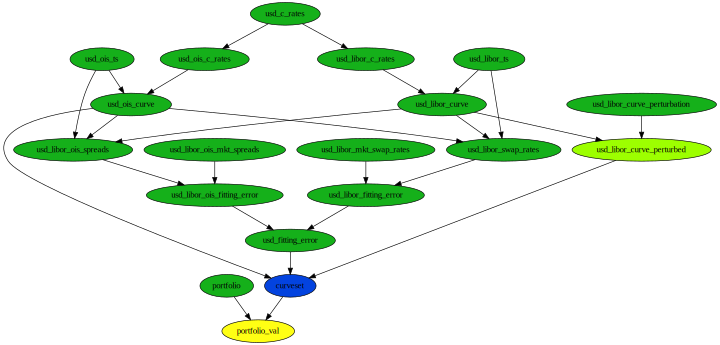

In [26]:
comp.add_node("usd_libor_curve_perturbation", value=(0, 1, 0.0))
comp.add_node(
    "usd_libor_curve_perturbed",
    lambda usd_libor_curve, usd_libor_curve_perturbation: create_perturbed_curve(
        usd_libor_curve, *usd_libor_curve_perturbation
    ),
)


def create_curveset(usd_libor_curve_perturbed, usd_ois_curve, usd_fitting_error):
    if np.max(np.abs(usd_fitting_error) > 0.00001):
        raise Exception("Fitting error > 0.1bps")
    return {"USD-LIBOR-3M": usd_libor_curve_perturbed, "USD-OIS": usd_ois_curve}


comp.add_node("curveset", create_curveset)

comp.draw(graph_attr={"size": "10,8"})

We can iterate over each year, and see the sensitivity of the portfolio to a change of 1bp in the forward swap rate for that year:

<Container object of 30 artists>

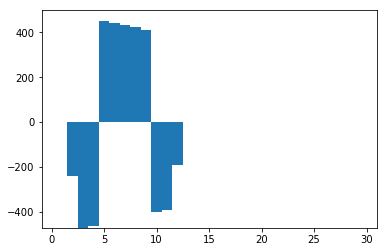

In [27]:
comp.compute("portfolio_val")
comp.insert("usd_libor_curve_perturbation", value=(0, 1, 0.0))
base_value = np.array(comp.value("portfolio_val"))
pert_values = np.empty((30, base_value.shape[0]))
delta_value = np.empty((30, base_value.shape[0]))
ts = np.arange(30)
for i in ts:
    comp.insert("usd_libor_curve_perturbation", value=(i, i + 1, 0.0001))
    comp.compute("portfolio_val")
    pert_values[i] = comp.value("portfolio_val")
    swap_rate_base = swap_rate(i, i + 1, 0.25, comp.value("usd_libor_curve"), comp.value("usd_ois_curve"))
    swap_rate_pert = swap_rate(i, i + 1, 0.25, comp.value("usd_libor_curve_perturbed"), comp.value("usd_ois_curve"))
    swap_rate_delta = swap_rate_pert - swap_rate_base
    delta_value[i] = 0.0001 / swap_rate_delta * (pert_values[i] - base_value)

plt.bar(ts, delta_value.sum(axis=1), np.diff(np.concatenate([[0], ts])))

## Conclusion

This concludes our interest example. We have shown that Loman makes it easy to simultaneously calibrate interest rate curves to market quotes, to value portfolios of interest rate derivatives, and to produce bucketed sensitivities.

The portfolio valuation also naturally extends to cover other interest rate derivatives.

The calibration approach - an external routine driving Loman to produce calibrated inputs for the computation - easily and naturally extends to calibrating to a global set of interest rate markets, with curveset drawing from many separate independent and interdependent calibrations. It can also extend to other markets, such as FX derivatives, listed options, credit derivatives.

Loman's ability to serialize computations allows the calibration to happen once, centrally, and be broadcast to user desktops for firm-wide consistent live valuation.

In short, we have only scratched the surface of what is possible with Loman with this example, and we look forward to further exploration in the future.